In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd /content/drive/My Drive/XLDLTK

/content/drive/My Drive/XLDLTK


In [0]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input"))

import warnings
warnings.filterwarnings('ignore')

# Any results you write to the current directory are saved as output.

# Import Data

In [0]:
print("imported data..")
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
print("Train set size:", train.shape)
print("Test set size:", test.shape)

imported data..
Train set size: (1460, 81)
Test set size: (1459, 80)


In [0]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [0]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


**Data Processing**

In [0]:
train_ID = train['Id']
test_ID = test['Id']
# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [0]:
# train['GarageYrOld'] = train.YrSold.astype(int) - train.GarageYrBlt

**So sánh độ tương quan thuộc tính so với giá**

In [0]:
(train.corr())["SalePrice"].sort_values(ascending = False)[1:]

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

**heatmap feature**

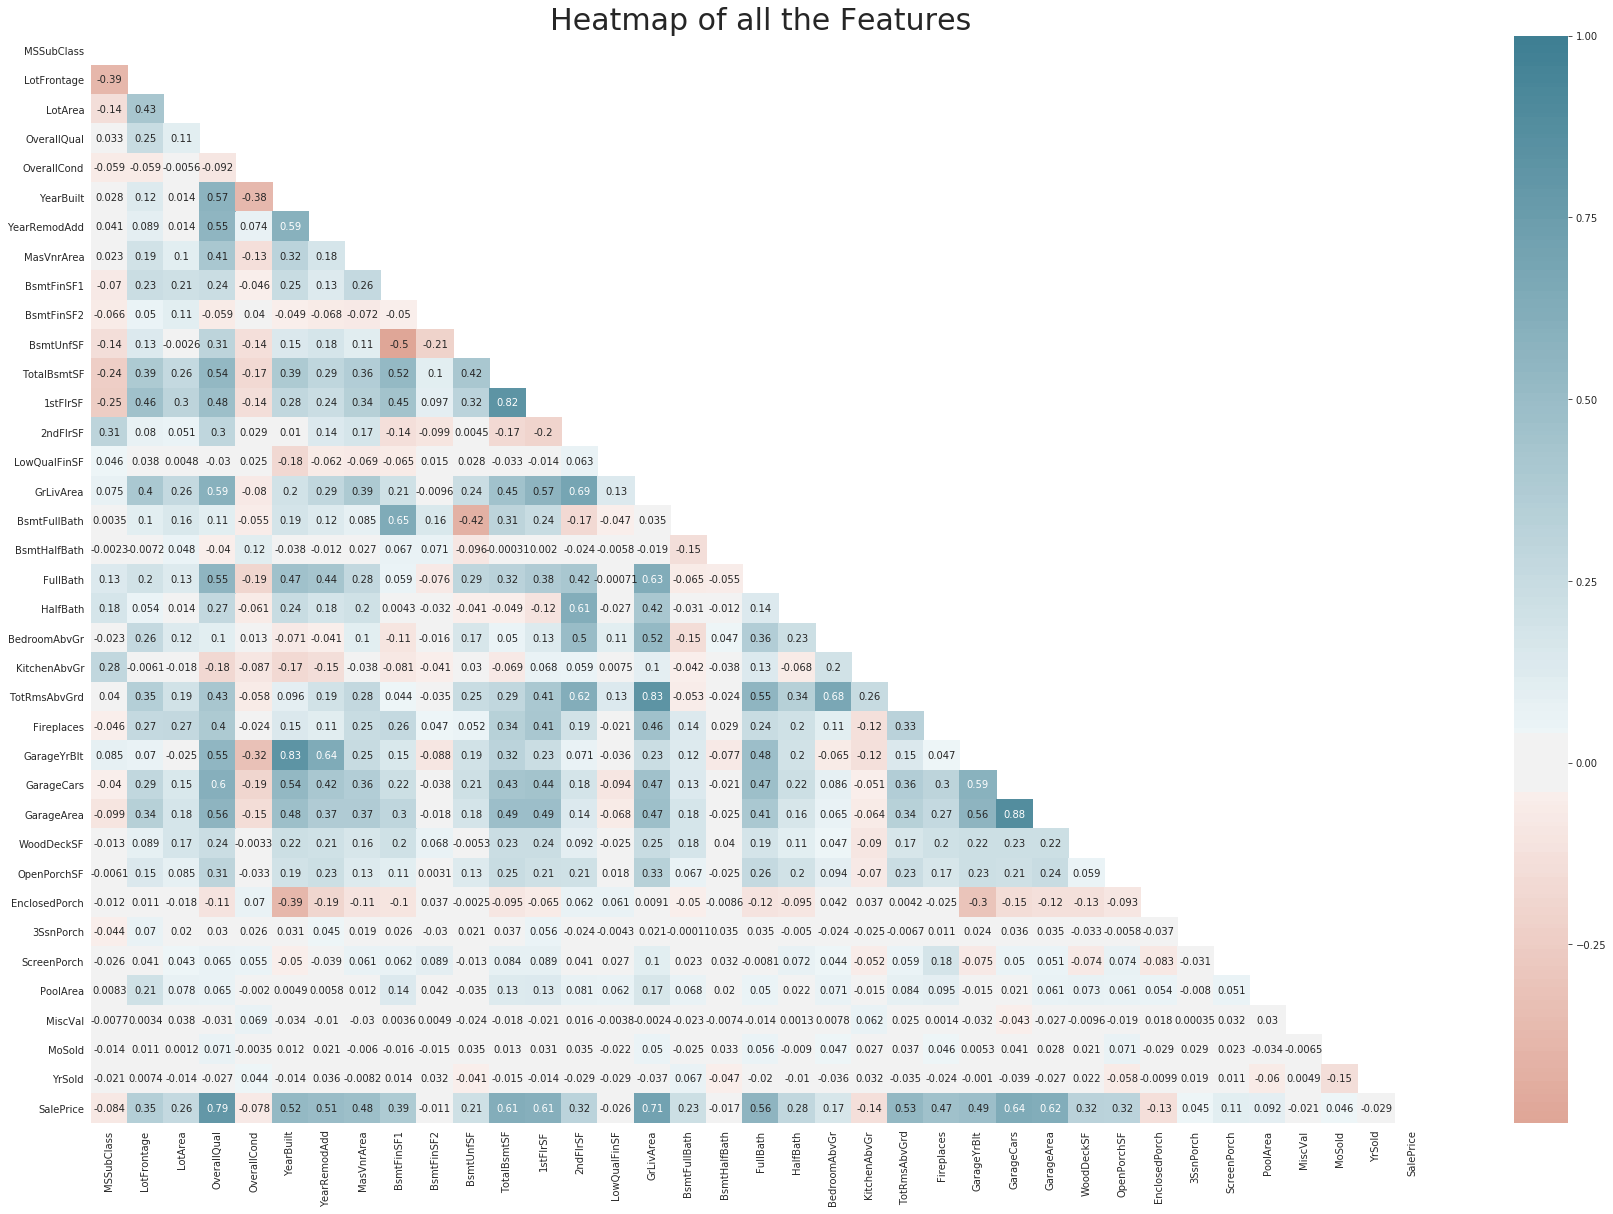

In [0]:
## Plot fig sizing. 
import matplotlib.style as style
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,20))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(train.corr(), dtype=np.bool)
# print(mask)
mask[np.triu_indices_from(mask)] = True
# print(mask)

sns.heatmap(train.corr(), cmap=sns.diverging_palette(20, 220, n=200), mask = mask, annot=True, center = 0, );
## Give title. 
plt.title("Heatmap of all the Features", fontsize = 30);

In [0]:
# sns.distplot(train['BedroomAbvGr'])
test.describe().T
# print(len(train['BedroomAbvGr'][train['BedroomAbvGr']==0]))
# train['BedroomAbvGr']
# train[train['BedroomAbvGr']==0]
# train['YearRemodAdd'].max()

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1459.0,57.378341,42.746880,20.0,20.00,50.0,70.00,190.0
LotFrontage,1232.0,68.580357,22.376841,21.0,58.00,67.0,80.00,200.0
LotArea,1459.0,9819.161069,4955.517327,1470.0,7391.00,9399.0,11517.50,56600.0
OverallQual,1459.0,6.078821,1.436812,1.0,5.00,6.0,7.00,10.0
OverallCond,1459.0,5.553804,1.113740,1.0,5.00,5.0,6.00,9.0
YearBuilt,1459.0,1971.357779,30.390071,1879.0,1953.00,1973.0,2001.00,2010.0
YearRemodAdd,1459.0,1983.662783,21.130467,1950.0,1963.00,1992.0,2004.00,2010.0
MasVnrArea,1444.0,100.709141,177.625900,0.0,0.00,0.0,164.00,1290.0
BsmtFinSF1,1458.0,439.203704,455.268042,0.0,0.00,350.5,753.50,4010.0
BsmtFinSF2,1458.0,52.619342,176.753926,0.0,0.00,0.0,0.00,1526.0


In [0]:
test[test['GarageYrBlt'] > 2009]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
42,20,FV,57.0,12853,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2010,2010,Gable,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,Ex,Po,No,GLQ,1032.0,Unf,0.0,610.0,1642.0,GasA,Ex,Y,SBrkr,1418,0,0,1418,1.0,0.0,1,1,1,1,Gd,6,Typ,1,Gd,Attchd,2010.0,RFn,3.0,852.0,TA,TA,Y,160,192,0,224,0,0,NaN,NaN,NaN,0,4,2010,New,Partial
148,20,RL,73.0,9803,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,7,5,2009,2010,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1214.0,1214.0,GasA,Ex,Y,SBrkr,1214,0,0,1214,0.0,0.0,2,0,2,1,Gd,6,Typ,0,NaN,Attchd,2010.0,RFn,2.0,520.0,TA,TA,Y,0,25,0,0,0,0,NaN,NaN,NaN,0,1,2010,New,Partial
1132,20,RL,68.0,8298,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Av,GLQ,583.0,Unf,0.0,963.0,1546.0,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2207.0,RFn,2.0,502.0,TA,TA,Y,132,0,0,0,0,0,NaN,NaN,NaN,0,9,2007,New,Partial


In [0]:
outlier = test['GarageYrBlt'] > 2200
test.at[outlier, 'GarageYrBlt'] = test[outlier]['YearRemodAdd'] 

In [0]:
# # customized_scatterplot(train.SalePrice, train.GrLivArea)
# style.use('fivethirtyeight')
# plt.subplots(figsize = (15,10))
# sns.distplot(train.LowQualFinSF)

Lets look at the distribution of our target variable to see if it fits a normal distribution, due to the parametric nature of our analysis procedure.

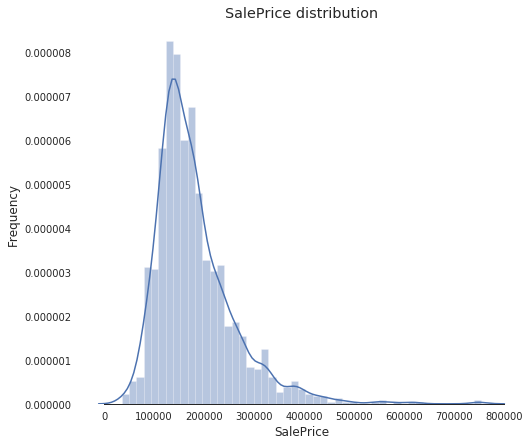

In [0]:
#Before the normalisation
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

# Deleting the more visibly obvious outliers
# 4500 exceeds the central tendecy of of the houses in that price point and all the houses in the dataset
# will deal with more subtle outlers later.
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)

> The graph shows that our data is skewed to the right.

This is to make sure that SalesPrice values are distributed normaly using function log1p which  applies log(1+x) to all elements of the column which fixes the skeweness of the distribution.


 mu = 12.02 and sigma = 0.40



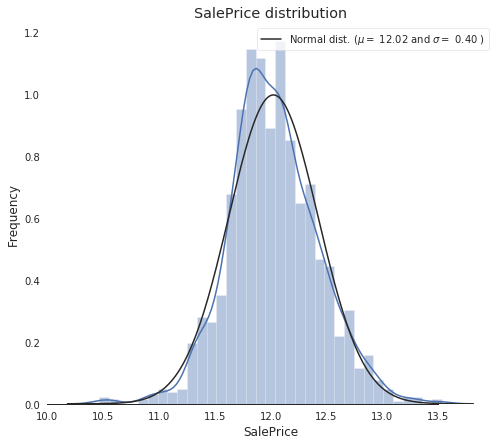

In [0]:

#We use the numpy fuction log1p 
train["SalePrice"] = np.log1p(train["SalePrice"])
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

> The graph shows that our data now looks more normal

In [0]:
y = train.SalePrice#.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# concatinate the train and the test set as features for tranformation to avoid mismatch
features = pd.concat([train_features, test_features])#.reset_index(drop=True)
print('Features size:', features.shape)

Features size: (2917, 79)


# Feature Engineering

We now start the process of preparing our features, we first find, the percentage of missing data in each column and we determine whether the threshold of missing values is acceptable or not.

In [0]:

# function for determining the threshold of missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:]

Percent of missing data


[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.43),
 ('FireplaceQu', 48.68),
 ('LotFrontage', 16.66),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45),
 ('GarageCond', 5.45),
 ('GarageType', 5.38),
 ('BsmtCond', 2.81),
 ('BsmtExposure', 2.81),
 ('BsmtQual', 2.78),
 ('BsmtFinType2', 2.74),
 ('BsmtFinType1', 2.71),
 ('MasVnrType', 0.82),
 ('MasVnrArea', 0.79),
 ('MSZoning', 0.14),
 ('Utilities', 0.07),
 ('BsmtFullBath', 0.07),
 ('BsmtHalfBath', 0.07),
 ('Functional', 0.07),
 ('Exterior1st', 0.03),
 ('Exterior2nd', 0.03),
 ('BsmtFinSF1', 0.03),
 ('BsmtFinSF2', 0.03),
 ('BsmtUnfSF', 0.03),
 ('TotalBsmtSF', 0.03),
 ('Electrical', 0.03),
 ('KitchenQual', 0.03),
 ('GarageCars', 0.03),
 ('GarageArea', 0.03),
 ('SaleType', 0.03),
 ('MSSubClass', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('LotConfig', 0.0),
 ('LandSlope', 0.0),
 ('Neighborhood', 0.0),
 ('Condition1', 0.0),
 ('Condition2', 0.0),
 ('Bl

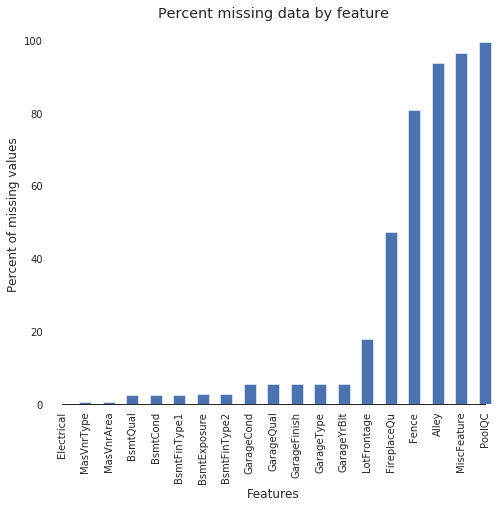

In [0]:
# visualising missing values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

These visualisation helps determine which values need to be imputed, We impute them by proceeding sequentially through features with missing values.

In [0]:
# df = pd.DataFrame()
# none = features['GarageFinish'].isna()
# # print(none)
# for e in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond' , 'GarageYrBlt']:
#   print(features[e].isna().sum())
# df.at[none, 'GarageType'] = features[none]['GarageType']
# not_nones = features[none]['GarageType']
# not_nones = np.invert(not_nones.isna())
# not_nones = df.index[not_nones].tolist()

# for not_none in not_nones:
#   for e in ['GarageFinish', 'GarageQual', 'GarageCond' , 'GarageYrBlt']:
#     features.at[not_none, e] = features[e].mode()

In [0]:

# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

# data description says NA means typical
features['Functional'] = features['Functional'].fillna('Typ')
# has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
features['Electrical'] = features['Electrical'].fillna("SBrkr")
#  Only one NA value, We set 'TA' (which is the most frequent) for the missing value in KitchenQual
features['KitchenQual'] = features['KitchenQual'].fillna("TA")

# Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
# Fill in again with most frequent
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

# data description says NA means "No Pool", majority of houses have no Pool at all in general.
features["PoolQC"] = features["PoolQC"].fillna("None")

garaYrNa = features['GarageYrBlt'].isna()
features.at[garaYrNa, 'GarageYrBlt'] = features[garaYrNa]['YearBuilt']

# Replacing missing data with 0 (Since No garage = no cars in such garage.)
for col in ('GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)

# Replacing missing data with None
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
    
# For all these categorical basement-related features, NaN means that there is no basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

# 'RL' is by far the most common value. So we can fill in missing values with 'RL'
features['MSZoning'] = features.groupby('Neighborhood')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

print('Features size:', features.shape)

Features size: (2917, 79)


In [0]:
# Filling the rest of the categorical features
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

In [0]:
# Filling in the rest of the NA's
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))


After imputing features with missing values, is there any remaining missing values?

In [0]:
# Check the state of missing values
missing = percent_missing(features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]

>  No more missing values

One of the other methods that we tried that did not work well in selecting the feature and improving the accuracy was Backward Elimination with Adjusted R-squared. (Expand below to view commented code.)

In [0]:
# import statsmodels.formula.api as sm
# def backwardElimination(x, sl):
#     numVars = len(x[0])
#     for i in range(0, numVars):
#         regressor_OLS = sm.OLS(y, x).fit()
#         maxVar = max(regressor_OLS.pvalues).astype(float)
#         if maxVar > sl:
#             for j in range(0, numVars - i):
#                 if (regressor_OLS.pvalues[j].astype(float) == maxVar):
#                     x = np.delete(x, j, 1)
#     regressor_OLS.summary()
#     return x

# #start elimination with 5% significance level for best parameters
# SL = 0.01
# X_opt = features
# y = y
# features = backwardElimination(X_opt, SL)

# More feature engineering

Looking at the distribution of the numeric features. Ideally we would like all our data to be normaly distributed. Id these is not normally distributed that could violate the assumptions of parametric statistics. If the data deviate strongly from the assumptions of a parametric procedure, using the parametric procedure could lead to incorrect conclusions.  

In [0]:
# refill outlier nếu năm xây dựng nhỏ hơn năm sửa chữa
outlier = features['YearRemodAdd'] < features['YearBuilt']
features.at[outlier, 'YearRemodAdd'] = features[outlier]['YearBuilt'] 

isRemodel = features['YearRemodAdd'] > features['YearBuilt']
# year remodel : thuộc tính xem nhà đã sửa chữa được bao lâu
features['YearRemod'] = features['YrSold'].astype(int) - features['YearRemodAdd']
features['YearRemod'] = features['YearRemod'].apply(lambda x: 0 if int(x) < 0 else x)
features.at[isRemodel, 'YearRemod'] = features[isRemodel]['YearRemod'].apply(lambda x: 0)

# Year old : thuộc tính tuổi thọ nhà, tính từ năm xây dựng tới năm bán
features['yearOld'] = features.YrSold.astype(int) - features.YearBuilt
features['yearOld'] = features['yearOld'].apply(lambda x : x if x >= 0 else 0)


features['GarageYrOld'] = features.YrSold.astype(int) - features.GarageYrBlt
features['GarageYrOld'] = features['GarageYrOld'].apply(lambda x: 0 if x < 0 else x )


# tuổi thọ nhà + thời gian sửa chữa 
# features['yearOld'] = features['yearOld'] + YearRemod


Visualize the destributions of the numeric features. This will allow us to visually see the ditributions of all our numeric data.

In [0]:
# First we need to find all numeric features in the data
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)

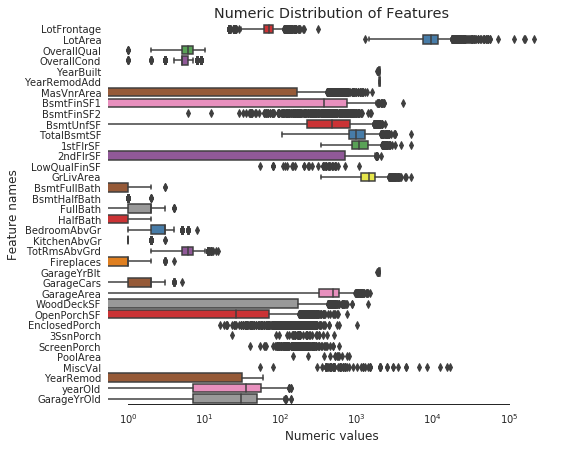

In [0]:
# Box plots for all our numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=features[numerics2] , orient="h", palette="Set1")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

 > The visualisation show that is some data that is not normaly distributed(Skewed)

In [0]:
# Find the skewed  numerical features

skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features


There are 28 numerical features with Skew > 0.5 :


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
MasVnrArea        2.621719
OpenPorchSF       2.529358
WoodDeckSF        1.844792
1stFlrSF          1.257286
LotFrontage       1.103039
GrLivArea         1.068750
YearRemod         1.031346
BsmtFinSF1        0.980645
BsmtUnfSF         0.919688
2ndFlrSF          0.861556
TotRmsAbvGrd      0.749232
Fireplaces        0.725278
HalfBath          0.696666
GarageYrOld       0.689083
TotalBsmtSF       0.671751
BsmtFullBath      0.622415
yearOld           0.598056
OverallCond       0.569314
BedroomAbvGr      0.326568
GarageArea        0.216857
OverallQual       0.189591
FullBath          0.165514
GarageCars       -0.219297
YearRemodAdd     -0.450131
YearBuilt        -0.599194
GarageYrBlt      -0.690152
dtype: float64

We use the scipy function boxcox1p which computes the Box-Cox transformation. The goal is to find a simple transformation that leads to normality. 

In [0]:
# Normalise skewed features
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))
# features['yearOld'] = boxcox1p(features['yearOld'], boxcox_normmax(features['yearOld'] + 1))

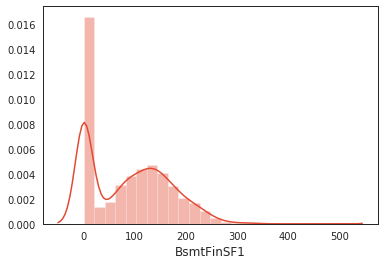

We check the data after normalisation, is there any remaining skewed values?

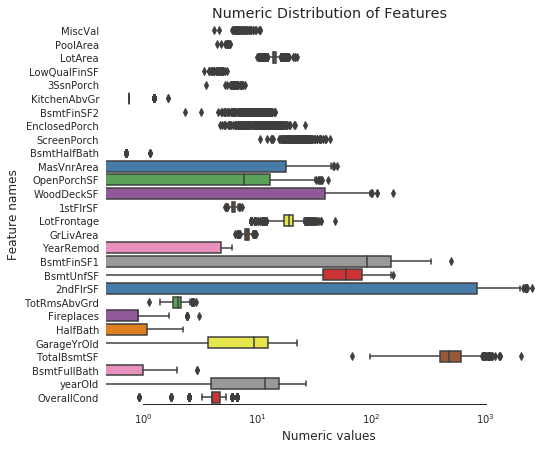

In [0]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=features[skew_index] , orient="h", palette="Set1")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

>  [MasVnrArea, OpenPorchSF, WoodDeckSF, BsmtFinSF1] could not be normalised therefore call to be droped.

Since area related features are very important to determine house prices, we add a few more features which is the total area of floors, bathrooms and porch area of each house before we continue droping these numeric colum

In [0]:
# Calculating totals before droping less significant columns

#  Adding total sqfootage feature 
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
#  Adding total bathrooms feature
features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
#  Adding total porch sqfootage feature
features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])


In [0]:

# feature xem có trang trí tường không
features['hasVeneer'] = features['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)

# feature xem nhà đã được sửa chữa chưa
features['isRemodel'] = np.where(features['YearRemodAdd'] > features['YearBuilt'], 1, 0)

features.drop(['YearBuilt', 'GarageYrBlt', 'YearRemodAdd'], axis=1, inplace=True)


In [0]:
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,...,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,YearRemod,yearOld,GarageYrOld,TotalSF,Total_Bathrooms,Total_porch_sf,hasVeneer,isRemodel
0,60,RL,18.144573,13.833054,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.991517,Gable,CompShg,VinylSd,VinylSd,BrkFace,19.433175,Gd,TA,PConc,Gd,TA,No,GLQ,144.117862,Unf,0.0,29.991055,422.488510,GasA,Ex,Y,SBrkr,...,0.99344,0.000000,2,1.068837,3,0.750957,Gd,2.261968,Typ,0.000000,None,Attchd,RFn,2.0,548.0,TA,TA,Y,0.000000,12.080309,0.000000,0.0,0.0,0.0,None,None,None,0.0,2,2008,WD,Normal,2.112674,3.095152,2.932489,1454.079522,3.527858,12.080309,1,0
1,20,RL,20.673625,14.117918,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,6.000033,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,181.719186,Unf,0.0,44.135415,593.888179,GasA,Ex,Y,SBrkr,...,0.00000,0.710895,2,0.000000,3,0.750957,TA,1.996577,Typ,0.903334,TA,Attchd,RFn,2.0,460.0,TA,TA,Y,56.184223,0.000000,0.000000,0.0,0.0,0.0,None,None,None,0.0,5,2007,WD,Normal,4.803373,10.728200,9.546894,600.123169,2.355448,56.184223,0,0
2,60,RL,18.668047,14.476512,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.991517,Gable,CompShg,VinylSd,VinylSd,BrkFace,17.768840,Gd,TA,PConc,Gd,TA,Mn,GLQ,110.441033,Unf,0.0,56.896536,450.079716,GasA,Ex,Y,SBrkr,...,0.99344,0.000000,2,1.068837,3,0.750957,Gd,1.996577,Typ,0.903334,TA,Attchd,RFn,2.0,608.0,TA,TA,Y,0.000000,9.901081,0.000000,0.0,0.0,0.0,None,None,None,0.0,9,2008,WD,Normal,0.000000,3.951851,3.706950,1496.595112,3.527858,9.901081,1,1
3,70,RL,17.249651,14.106196,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,3.991517,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,61.795315,Unf,0.0,64.808858,378.854568,GasA,Gd,Y,SBrkr,...,0.99344,0.000000,1,0.000000,3,0.750957,Gd,2.137369,Typ,0.903334,Gd,Detchd,Unf,3.0,642.0,TA,TA,Y,0.000000,8.966115,16.020711,0.0,0.0,0.0,None,None,None,0.0,2,2006,WD,Abnorml,0.000000,20.888989,4.058390,1289.359693,1.993440,24.986827,0,1
4,60,RL,21.314283,15.022008,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,3.991517,Gable,CompShg,VinylSd,VinylSd,BrkFace,25.404164,Gd,TA,PConc,Gd,TA,Av,GLQ,136.624601,Unf,0.0,61.166379,545.309927,GasA,Ex,Y,SBrkr,...,0.99344,0.000000,2,1.068837,4,0.750957,Gd,2.373753,Typ,0.903334,TA,Attchd,RFn,3.0,836.0,TA,TA,Y,42.245702,14.271568,0.000000,0.0,0.0,0.0,None,None,None,0.0,12,2008,WD,Normal,2.692370,4.344669,4.058390,1824.496011,3.527858,56.517270,1,0


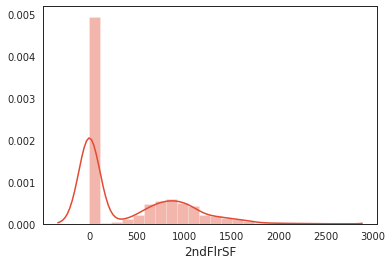

In [0]:
sns.distplot(features['2ndFlrSF'])

In [0]:
# Not normaly distributed can not be normalised and has no central tendecy
features = features.drop(['MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtFinSF1','2ndFlrSF'], axis=1)

PoolArea          15.595057
3SsnPorch          8.862045
LowQualFinSF       8.492615
MiscVal            5.237983
BsmtHalfBath       3.779434
KitchenAbvGr       3.778336
ScreenPorch        3.152631
BsmtFinSF2         2.578329
EnclosedPorch      2.149133
TotalSF            0.960159
HalfBath           0.732625
Total_porch_sf     0.643751
BsmtFullBath       0.616643
Fireplaces         0.553135
YearRemod          0.550773
dtype: float64


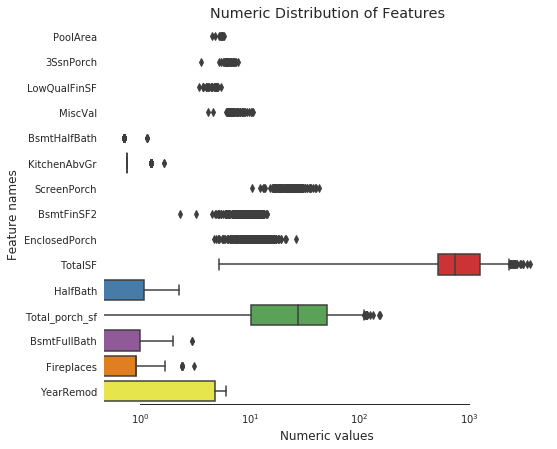

In [0]:
# Check the distribution after dopping the skewed features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics3 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics3.append(i)
        
skew_features = features[numerics3].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skew_features[skew_features > 0.5]
print(high_skew)
skew_index = high_skew.index

sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=features[skew_index] , orient="h", palette="Set1")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)


> The are no more skewed numerical variables

In [0]:
# Adding new simplified features (1 = present, 0 = not present)
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
# features['hasPorch']= features['Total_porch_sf'].apply(lambda x: 1 if x > 0 else 0)
print('Features size:', features.shape)

Features size: (2917, 83)


In [0]:
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,LowQualFinSF,...,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,YearRemod,yearOld,GarageYrOld,TotalSF,Total_Bathrooms,Total_porch_sf,hasVeneer,isRemodel,haspool,hasgarage,hasbsmt,hasfireplace
0,60,RL,18.144573,13.833054,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.991517,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,0.0,29.991055,422.488510,GasA,Ex,Y,SBrkr,5.939034,0.0,...,2,1.068837,3,0.750957,Gd,2.261968,Typ,0.000000,None,Attchd,RFn,2.0,548.0,TA,TA,Y,0.000000,0.0,0.0,0.0,None,None,None,0.0,2,2008,WD,Normal,2.112674,3.095152,2.932489,1454.079522,3.527858,12.080309,1,0,0,1,1,0
1,20,RL,20.673625,14.117918,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,6.000033,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,0.0,44.135415,593.888179,GasA,Ex,Y,SBrkr,6.234990,0.0,...,2,0.000000,3,0.750957,TA,1.996577,Typ,0.903334,TA,Attchd,RFn,2.0,460.0,TA,TA,Y,0.000000,0.0,0.0,0.0,None,None,None,0.0,5,2007,WD,Normal,4.803373,10.728200,9.546894,600.123169,2.355448,56.184223,0,0,0,1,1,1
2,60,RL,18.668047,14.476512,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.991517,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,0.0,56.896536,450.079716,GasA,Ex,Y,SBrkr,5.994336,0.0,...,2,1.068837,3,0.750957,Gd,1.996577,Typ,0.903334,TA,Attchd,RFn,2.0,608.0,TA,TA,Y,0.000000,0.0,0.0,0.0,None,None,None,0.0,9,2008,WD,Normal,0.000000,3.951851,3.706950,1496.595112,3.527858,9.901081,1,1,0,1,1,1
3,70,RL,17.249651,14.106196,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,3.991517,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,0.0,64.808858,378.854568,GasA,Gd,Y,SBrkr,6.027704,0.0,...,1,0.000000,3,0.750957,Gd,2.137369,Typ,0.903334,Gd,Detchd,Unf,3.0,642.0,TA,TA,Y,16.020711,0.0,0.0,0.0,None,None,None,0.0,2,2006,WD,Abnorml,0.000000,20.888989,4.058390,1289.359693,1.993440,24.986827,0,1,0,1,1,1
4,60,RL,21.314283,15.022008,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,3.991517,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,0.0,61.166379,545.309927,GasA,Ex,Y,SBrkr,6.161221,0.0,...,2,1.068837,4,0.750957,Gd,2.373753,Typ,0.903334,TA,Attchd,RFn,3.0,836.0,TA,TA,Y,0.000000,0.0,0.0,0.0,None,None,None,0.0,12,2008,WD,Normal,2.692370,4.344669,4.058390,1824.496011,3.527858,56.517270,1,0,0,1,1,1


In [0]:
def customized_scatterplot(y, x):
        ## Sizing the plot. 
    style.use('fivethirtyeight')
    plt.subplots(figsize = (15,10))
    ## Plotting target variable with predictor variable(OverallQual)
    sns.scatterplot(y = y, x = x);
# customized_scatterplot(train.SalePrice, train.YrSold.astype(int) - train.YearBuilt)

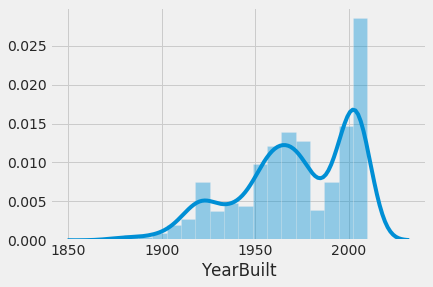

In [0]:
sns.distplot(train.YearBuilt)

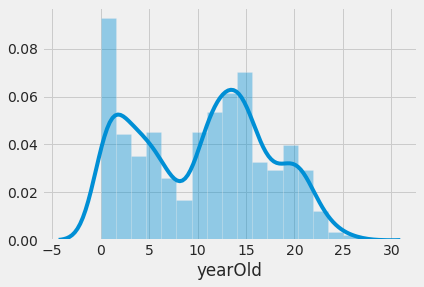

In [0]:
sns.distplot(features.yearOld)

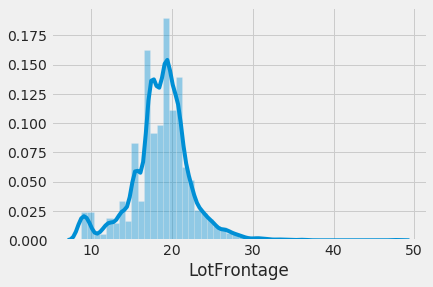

In [0]:
sns.distplot(features.LotFrontage)
# features.LotFrontage.min()

In [0]:
# Encoding the finalized features
final_features = pd.get_dummies(features)#.reset_index(drop=True)
print('Features size:', features.shape)
final_features.head()

Features size: (2917, 83)


,LotFrontage,LotArea,OverallQual,OverallCond,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YearRemod,yearOld,GarageYrOld,TotalSF,Total_Bathrooms,Total_porch_sf,hasVeneer,isRemodel,haspool,hasgarage,hasbsmt,hasfireplace,MSSubClass_120,MSSubClass_150,MSSubClass_160,...,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,18.144573,13.833054,7,3.991517,0.0,29.991055,422.488510,5.939034,0.0,8.353543,0.99344,0.000000,2,1.068837,3,0.750957,2.261968,0.000000,2.0,548.0,0.000000,0.0,0.0,0.0,0.0,2.112674,3.095152,2.932489,1454.079522,3.527858,12.080309,1,0,0,1,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20.673625,14.117918,6,6.000033,0.0,44.135415,593.888179,6.234990,0.0,7.974693,0.00000,0.710895,2,0.000000,3,0.750957,1.996577,0.903334,2.0,460.0,0.000000,0.0,0.0,0.0,0.0,4.803373,10.728200,9.546894,600.123169,2.355448,56.184223,0,0,0,1,1,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,18.668047,14.476512,7,3.991517,0.0,56.896536,450.079716,5.994336,0.0,8.408064,0.99344,0.000000,2,1.068837,3,0.750957,1.996577,0.903334,2.0,608.0,0.000000,0.0,0.0,0.0,0.0,0.000000,3.951851,3.706950,1496.595112,3.527858,9.901081,1,1,0,1,1,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,17.249651,14.106196,7,3.991517,0.0,64.808858,378.854568,6.027704,0.0,8.358662,0.99344,0.000000,1,0.000000,3,0.750957,2.137369,0.903334,3.0,642.0,16.020711,0.0,0.0,0.0,0.0,0.000000,20.888989,4.058390,1289.359693,1.993440,24.986827,0,1,0,1,1,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,21.314283,15.022008,8,3.991517,0.0,61.166379,545.309927,6.161221,0.0,8.669321,0.99344,0.000000,2,1.068837,4,0.750957,2.373753,0.903334,3.0,836.0,0.000000,0.0,0.0,0.0,0.0,2.692370,4.344669,4.058390,1824.496011,3.527858,56.517270,1,0,0,1,1,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


Separating the training(X,y) and the testing(X_sub) set

In [0]:
# Spliting the data back to train(X,y) and test(X_sub)
X = final_features.iloc[:len(y), :]
X_test = final_features.iloc[len(X):, :]
print('Features size for train(X,y) and test(X_test):')
print('X', X.shape, 'y', y.shape, 'X_test', X_test.shape)

Features size for train(X,y) and test(X_test):
X (1458, 336) y (1458,) X_test (1459, 336)


# Finalising features

Outlier removal is usually safe, for outliers that are very visible in certain features. We decided to delete these outliers as they are  likely to introduce bias in our regression functions.


In [0]:
# # Finding numeric features
# sns.set_style("dark")
# numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# numerics4 = []
# for i in X.columns:
#     if X[i].dtype in numeric_dtypes:
#         if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
#             pass
#         else:
#             numerics4.append(i)     
# # visualising some more outliers in the data values
# fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 80))
# plt.subplots_adjust(right=2)
# plt.subplots_adjust(top=2)

# cmap = sns.cubehelix_palette(dark=0.3, light=0.8, as_cmap=True)

# for i, feature in enumerate(list(X[numerics4]), 1):    
#     plt.subplot(len(list(numerics4)), 4, i)
#     sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', size='SalePrice', palette=cmap, data=train)
        
#     plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
#     plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
#     for j in range(2):
#         plt.tick_params(axis='x', labelsize=12)
#         plt.tick_params(axis='y', labelsize=12)
    
#     plt.legend(loc='best', prop={'size': 10})
        
# plt.show()

In [0]:
# Removes outliers 
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])
print(X.shape, y.shape)

(1453, 336) (1453,)


In [0]:
# Removes colums where the threshold of zero's is (> 99.95), means has only zero values 
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.95:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')
print(overfit)

X = X.drop(overfit, axis=1).copy()
X_test = X_test.drop(overfit, axis=1).copy()

print('X', X.shape, 'y', y.shape, 'X_test', X_test.shape)

['MSSubClass_150', 'Utilities_None', 'MSZoning_C (all)']
X (1453, 333) y (1453,) X_test (1459, 333)


In [0]:
print('X', X.shape, 'y', y.shape, 'X_test', X_test.shape)

X (1453, 333) y (1453,) X_test (1459, 333)


# Start Model Building

We use the kfolds Cross Validation function where K=10 which is the number of holdout sets. The function has no shuffle attribute, we add then one line of code shuffle=True, in order to shuffle the dataset prior to cross-validation.


In [0]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# model scoring and validation function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,scoring="neg_mean_squared_error",cv=kfolds))
    return (rmse)

# rmsle scoring function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

Created 3 models RidgeCV, LassoCV, ElasticNetCV and are linear models with built-in cross validation.
We a going to use these nodels together to make the final prediction.

In [0]:
from xgboost import XGBRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor


# setup models hyperparameters using a pipline
# The purpose of the pipeline is to assemble several steps that can be cross-validated together, while setting different parameters.
# This is a range of values that the model considers each time in runs a CV
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]


# Kernel Ridge Regression : made robust to outliers
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

# LASSO Regression : made robust to outliers
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                    alphas=alphas2,random_state=42, cv=kfolds))

# Elastic Net Regression : made robust to outliers
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, 
                         alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))

xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                      max_depth=3, min_child_weight=0,
                      gamma=0, subsample=0.7,
                      colsample_bytree=0.7,
                      objective='reg:squarederror', nthread=-1,
                      scale_pos_weight=1, seed=27,
                      reg_alpha=0.00006)

svr = make_pipeline(RobustScaler(),
                    SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

lightgbm = LGBMRegressor(objective='regression', 
                        num_leaves=4,
                        learning_rate=0.01, 
                        n_estimators=5000,
                        max_bin=200, 
                        bagging_fraction=0.75,
                        bagging_freq=5, 
                        bagging_seed=7,
                        feature_fraction=0.2,
                        feature_fraction_seed=7,
                        verbose=-1,
                        )

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                max_depth=4, max_features='sqrt',
                                min_samples_leaf=15, min_samples_split=10, 
                                loss='huber', random_state =5)

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

# store models, scores and prediction values 
models = {'Ridge': ridge,
          'Lasso': lasso, 
          'ElasticNet': elasticnet,
          'Xgboost': xgboost,
          'SVR': svr,
          'lightgbm': lightgbm,
          'GradientBoostingRegressor': gbr}
          
predictions = {}
scores = {}

# for name, model in models.items():
    
#     model.fit(X, y)
#     predictions[name] = np.expm1(model.predict(X))
    
#     score = cv_rmse(model, X=X)
#     scores[name] = (score.mean(), score.std())
    

# Evaluate Model Performance

Now we use 10-fold stacking , we first split the training data into 10 folds. Then we will do 10 iterations. In each iteration, we train every base model on 9 folds and predict on the remaining fold (holdout fold).

In [0]:
#Fit the training data X, y
print('----START Fit----',datetime.now())
print('Elasticnet')
elastic_model = elasticnet.fit(X, y)
print('Lasso')
lasso_model = lasso.fit(X, y)
print('Ridge')
ridge_model = ridge.fit(X, y)
print('Xgboost')
xgboost_model = xgboost.fit(X, y)
print('SVR')
svr_model = svr.fit(X, y)
print('lightgbm')
lightgbm_model = lightgbm.fit(X, y)

print('gbr')
gbr_model = gbr.fit(X, y)

print('stack_gen')
# stack_gen_model = stack_gen.fit(np.array(X), np.array(y))


----START Fit---- 2019-12-11 11:37:38.471689
Elasticnet
Lasso
Ridge
Xgboost
SVR
lightgbm
gbr
stack_gen


# Ensemble prediction on blended models

All of the models individually achieved scores between 0.10 and 0.13, but when the predictions of those models are blended, they get about 0.090. That's because those models are actually overfitting to certain degree. They are very good at predicting a subset of houses, and they fail at predicting the rest of the dataset. When their predictions are blended, those models complement each other.

In [0]:
# model blending function using fitted models to make predictions
def blend_models(X):
    return (  (elastic_model.predict(X))\
            + (lasso_model.predict(X)) \
            + (xgboost_model.predict(X))\
            + (svr_model.predict(X))\
            + (lightgbm_model.predict(X))\
            + (gbr_model.predict(X))\
            + (ridge_model.predict(X)*4))/10
            # + (stack_gen_model.predict(np.array(X)) ) )/11
blended_score = rmsle(y, blend_models(X))
print('RMSLE score on train data:')
print(blended_score) #  0.07501011015088116

RMSLE score on train data:
0.07598442452193371


# Model Predictions

In [0]:
# get the target variable/ y_test with X_test
print('Predict submission') # and at the same time minimizing the error between the predicted value and actual observe
y_test_r = pd.read_csv("./sample_submission.csv")
submission = pd.read_csv("./sample_submission.csv")
y_test = np.log1p(y_test_r.iloc[:,1].values)
submission.iloc[:,1] = np.expm1(blend_models(X_test))
blended_score = rmsle(y_test, blend_models(X_test))
print(blended_score) # 0.3853984496369594 0.3843405644064449

Predict submission
0.3843405644064449


# Submission

In [0]:
q1 = submission['SalePrice'].quantile(0.01)
q3 = submission['SalePrice'].quantile(0.99)
# IQR = q3 - q1

# q1 = (q1 - 1.5 * IQR)
# q3 = (q3 + 1.5 * IQR)

print(q1, q3)
# print(submission['SalePrice'].quantile(0.01), submission['SalePrice'].quantile(0.99))
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.8)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q3 else x*1.1)

submission.to_csv("new_submission1012.csv", index=False)

print('Save submission', datetime.now(),)

64670.31891221578 450161.2945666859
Save submission 2019-12-11 11:38:36.563304


In [0]:
submission.head(n=10)

,Id,SalePrice
0,1461,120860.106578
1,1462,160275.537946
2,1463,185147.594650
3,1464,201673.012446
4,1465,187702.408716
5,1466,169285.300758
6,1467,176724.753692
7,1468,162158.847907
8,1469,192567.785443
9,1470,121933.487234
